# シルエット自動計測のための前処理

ベジエ曲線を当てはめる対象となる点列を抽出するプログラム

- 上下のブレの多い部分を自動でカット

1. 上から10％と20％の高さのシルエットの中点同士を結ぶ直線の法線方向を求める
2. 法線が右肩上がりのばあいは、左の輪郭の上から10％ポイント、左肩上がりの場合は右の輪郭の上から10％ポイントから先に求めた法線方向へ直線を伸ばす。その直線より上の輪郭点は対象から除外。
3. 残った輪郭線の点列を下部の突端で左右に分ける。
4. 同じ比率の位置同士を結んだ線分の長さを太さと定義する。（単純に序列で対応づけているので正確ではないが、そう外れてもいないと思う。）
5. 最大の太さを求める。
6. 最大の太さに対して20％未満の太さとなる輪郭点を処理対象から除外する。

In [1]:
from sympy import *
from sympy.abc import a,b,c
init_session()
import numpy as np
%matplotlib inline
from sympy import var

IPython console for SymPy 1.2 (Python 3.6.6-64-bit) (ground types: gmpy)

These commands were executed:
>>> from __future__ import division
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at http://docs.sympy.org/1.2/



# 前処理のための関数群
### 汎用の関数

In [2]:
#  汎用の関数
from skimage.morphology import skeletonize, skeletonize_3d
import matplotlib.pyplot as plt
from skimage.util import invert
from skimage import io
import skimage.data
import skimage.color
import os
import numpy as np
import cv2
import numpy as np
from PIL import Image

# この関数は画像の入った複数のフォルダが１つのフォルダに入っていることを前提としている。
#  指定フォルダ直下の画像ファイルは無視する。直下のフォルダの中しか見ず、さらにサブフォルダがあっても再帰的に探すようなことはしない。

def listimage(path='シルエット', needThum=False):

    directory = os.listdir(path)
    
    # まずフォルダを全部リストアップ　→ folders
    folders = []
    for x in os.listdir(path):  
        if os.path.isdir(path + '/'+x) and x[0] != '.' and x[0] !='_':  #パスに取り出したオブジェクトを足してフルパスに
            folders.append(path + '/'+x)
    # print(folders)

    # folders の各フォルダの中にある jpg ファイルをリストアップ → ffiles
    # ffiles はフォルダごとのリストのリスト
    ffiles = []
    for x in folders:
        files = []
        for f in os.listdir(x):
            entry = x + '/'+f
            if os.path.isfile(entry) and f[-4:]=='.jpg' and f[0] != '.':
                files.append(entry)
        ffiles.append(files)
    
    if needThum: # サムネイルの作成
        i = 0
        for cat in ffiles:
            # print(folders[i])
            sam = Image.new('RGB', (800,600),(0,0,0))
            row = col = 0
            for rad in cat:
                img = Image.open(rad, 'r')
                thumbnail_size = (100, 100)
                img.thumbnail(thumbnail_size)
                sam.paste(img,(col,row))
                col += 100
                if col == 800:
                    col = 0
                    row += 100
                # plt.imshow(sam)
            sam.save('{}THUM.png'.format(folders[i]), 'PNG')
            print("saved {}".format(folders[i]))
            i +=1

    return folders,ffiles

# マージンをつける
def makemargin(img,mr=2):
    h,w = img.shape[:2]
    w2 = mr*w
    h2 = mr*h
    x1 = int((w2-w)/2)
    y1 = int((h2-h)/2)
    img2 = np.zeros((h2,w2),np.uint8)
    img2[y1:y1+h,x1:x1+w] = img
    return img2

# ２枚の画像をサイズを並べた画像を作成する
def mkparaimage(img1,img2):
    h1,w1 = img1.shape[:2]
    h2,w2 = img2.shape[:2]
    if img1.ndim == 2:
        img11 = np.zeros((h1,w1,3))
        img11[:,:,0]=img11[:,:,1]=img11[:,:,2]=img1
    else:
        img11=img1
    if img2.ndim == 2:
        img22 = np.zeros((h2,w2,3))
        img22[:,:,0]=img22[:,:,1]=img22[:,:,2]=img2
    else:
        img22=img2
    paraimg = 255*np.ones((max(h1,h2),w1+w2+10,3),dtype=np.uint8)
    
    paraimg[0:h1,0:w1,:] = img11
    paraimg[0:h2,w1+10:,:]=img22
    
    return paraimg

# mkparaimage で２枚並べた画像を表示
def imshowpara(img1,img2):
    plotimg(mkparaimage(img1,img2))


# 処理結果画像（fimg)に処理前画像（bimg)の輪郭を描く
def draw2(bimg,fimg):
    if len(bimg.shape)==3:
        bimg2 = cv2.cvtColor(bimg,cv2.COLOR_BGR2GRAY)
    else:
        bimg2 = bimg.copy()
    if len(fimg.shape)==3:
        fimg2 = fimg.copy()
    else:
        fimg2 = cv2.cvtColor(fimg,cv2.COLOR_GRAY2BGR)
    # 処理前画像の輪郭
    # canvas = np.zeros_like(fimg2)
    canvas = fimg2.copy()
    _ret,bwimg = cv2.threshold(bimg2,128,255,cv2.THRESH_BINARY) # 白画素は255にする
    _img,cnt,hierarchy = cv2.findContours(bwimg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # canvas = cv2.drawContours(canvas, cnt, -1, (255,230,230), thickness=-1)
    canvas = cv2.drawContours(canvas, cnt, -1, (255,0,200), thickness=1)
    # return cv2.addWeighted(fimg2, 0.5, canvas, 0.5,0)
    return canvas[:,:,::-1] # opencv -> PIL

# (x1,y1)から（x2,y2) に向かう直線のX軸に対する角度
def getDegreeOfALine(x1,y1,x2,y2):
        dx = x2-x1
        dy = y2-y1
        if dx == 0:
            deg = 90
        elif dx >0:
            deg = 180.0*np.arctan(dy/dx)/np.pi
        else:
            deg = 180*(1+np.arctan(dy/dx)/np.pi)
        return deg
    
# (x1,y1)から（x2,y2) に向かう直線の延長上の十分離れた２点の座標
def getTerminalPsOnLine(x1,y1,x2,y2):
        dx = x2-x1
        dy = y2-y1
        s1 = int(x1 + 1000*dx)
        t1 = int(y1 + 1000*dy)
        s2 = int(x1 - 1000*dx)
        t2 = int(y1 - 1000*dy)
        return s1,t1,s2,t2

# 画像を標準化するための関数

In [3]:
# import matplotlib.pyplot as plt
# import numpy as np
# import cv2

CONTOURS_APPROX = 0.005 # 輪郭近似精度
HARRIS_PARA = 1.0 # ハリスコーナー検出で、コーナーとみなすコーナーらしさの指標  1.0 なら最大値のみ
CONTOURS_APPROX = 0.0002 # 輪郭近似精度
SHRINK = 0.8 # 0.75 # 収縮膨張で形状を整える時のパラメータ
GAUSSIAN_RATE1= 0.25 # 先端位置を決める際に使うガウスぼかしの程度を決める係数
GAUSSIAN_RATE2 = 0.1 # 仕上げに形状を整えるためのガウスぼかしの程度を決める係数
    
# ガウスぼかし、膨張収縮、輪郭近似で形状を整える関数
# 形状の細かな変化をガウスぼかし等でなくして大まかな形状にする関数
def RDreform(img,ksize=5,shrink=SHRINK):
    # ガウスぼかしを適用してシルエットを滑らかにする
    img2 = cv2.GaussianBlur(img,(ksize,ksize),0) # ガウスぼかしを適用
    _ret,img2 = cv2.threshold(img2, 127, 255, cv2.THRESH_BINARY) # ２値化
    # 収縮・膨張によりヒゲ根を除去する
    area0 = np.sum(img2) # img2 の画素数*255 になるはず
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(ksize,ksize)) # 円形カーネル
    tmpimg = cv2.erode(img2,kernel,iterations = 1) # 収縮１回目
    area1 = np.sum(tmpimg) # 収縮したので area0 より少なくなる
    n = 1
    while area1  > shrink*area0: # 面積が SHRINK倍以下になるまで繰り返す
        tmpimg = cv2.erode(tmpimg,kernel,iterations = 1)
        area1 = np.sum(tmpimg) 
        n += 1
    img3 = cv2.dilate(tmpimg,kernel,iterations = n) # 同じ回数膨張させる
    # あらためて輪郭を求め直す
    # まず最大の領域を取り出す
    _lnum, labelimg, cnt, _cog =cv2.connectedComponentsWithStats(img3)
    areamax = np.argmax(cnt[1:,4])+1 # ０番を除く面積最大値のインデックス
    img3 = np.zeros_like(img3)
    img3[labelimg==areamax]=255
    _img,cnt,hierarchy = cv2.findContours(img3, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) #  あらためて輪郭を抽出
    outimg = np.zeros_like(img3)
    # outimg = cv2.drawContours(outimg, cnt, 0, 255, thickness=-1) 
    # 近似輪郭を求めて描きなおす
    # area = cv2.contourArea(cnt[0]) # 面積
    perimeter = cv2.arcLength(cnt[0],True) # 周囲長
    epsilon = CONTOURS_APPROX*perimeter # 周囲長をもとに精度パラメータを決定
    # 概形抽出
    approx = cv2.approxPolyDP(cnt[0],epsilon,True)
    outimg = cv2.drawContours(outimg, [approx], 0, 255, thickness=-1) 

    return outimg

In [4]:
# 　重心と先端の位置を返す関数
#   先端位置はシルエットをガウスぼかしで滑らかにした上で曲率の高い場所
def getCoGandTip(src, showResult=False, useOldImage=True):
    # useOldImage = True なら元の画像を使って結果を表示、Falseなら滑らかにした画像
    img = makemargin(src) # 作業用のマージンを確保
    img2 = img.copy() # 加工前の状態を保存
    # ガウスぼかしを適用してシルエットを滑らかにする
    ksize = int(GAUSSIAN_RATE1*img.shape[1]/2)*2+1 # ぼかし量  元の図形の幅に応じて決める
    img = cv2.GaussianBlur(img,(ksize,ksize),0) # ガウスぼかしを適用
    # ２値化してシルエットを求め直す
    _ret,img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY) # ２値化
    # Harris コーナ検出
    himg = np.float32(img)
    himg = cv2.cornerHarris(himg,blockSize=3,ksize=3,k=0.04)
    # コーナー度合いが最大の領域を求める
    wimg = np.zeros_like(img)
    wimg[himg>=HARRIS_PARA*himg.max()]=255 # コーナー度最大値の領域を２５５で塗りつぶす。
    # 最大値に等しい値の領域が１点とは限らないし、いくつかの点の塊になるかもしれない
    _lnum, _img, cnt, cog = cv2.connectedComponentsWithStats(wimg)
    areamax = np.argmax(cnt[1:,4])+1 # ０番を除く面積最大値のインデックス
    t_x,t_y = np.round(cog[areamax]) # 重心の位置

    # コア全体の重心の位置を求める
    _lnum, _img, _cnt, cog = cv2.connectedComponentsWithStats(img)
    c_x,c_y = np.round(cog[1])

    # コーナーの場所のマーキング（デバッグ用）
    # himg = cv2.dilate(himg,None,iterations = 3)
    # img3[himg>=HARRIS_PARA*himg.max()]=[0,0,255]

    if showResult: # 
        if useOldImage:
            img3 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
        else:
            img3 = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
        plt.figure(figsize=(10,7),dpi=75)
        img3=cv2.circle(img3,(int(t_x),int(t_y)),5,(0,255,0),2)
        img3=cv2.circle(img3,(int(c_x),int(c_y)),5,(255,255,0),2)
        x1,y1,x2,y2= getTerminalPsOnLine(c_x,c_y,t_x,t_y)
        img3=cv2.line(img3,(x1,y1),(x2,y2),(255,0,255),2)                 
        img3 = cv2.cvtColor(img3,cv2.COLOR_BGR2RGB)
        plt.subplot(122), plt.imshow(img3)
        plt.show()
        
    # 結果を返す (c_x,c_y) 重心　　(t_x,t_y)  先端の位置 img2 滑らかになったシルエット画像
    return c_x,c_y,t_x,t_y

# 回転した上でマージンをカットした画像を返す
def roteteAndCutMargin(img,deg,c_x,c_y): 
    # 非常に稀であるが、回転すると全体が描画領域外に出ることがあるので作業領域を広く確保
    # mat = cv2.getRotationMatrix2D((x0,y0), deg-90, 1.0) # アフィン変換マトリクス
    bigimg = makemargin(img,mr=10) # 作業用のマージンを確保
    h3,w3 = img.shape[:2]
    h4,w4 = bigimg.shape[:2]
    mat = cv2.getRotationMatrix2D((c_x+(w4-w3)/2,c_y+(h4-h3)/2), deg, 1.0) # アフィン変換マトリクス

    # アフィン変換の適用
    bigimg = cv2.warpAffine(bigimg, mat, (0,0),1)

    # 再び最小矩形を求めて切り出す。ただし、マージンを５つける
    _nLabels, _labelImages, data, _center = cv2.connectedComponentsWithStats(bigimg) 
    resultimg = bigimg[data[1][1]-5:data[1][1]+data[1][3]+5,data[1][0]-5:data[1][0]+data[1][2]+5]

    return resultimg

# 重心から上の重心と、重心位置で断面の中心を返す関数
#   この関数ではぼかしは行わない。
def getUpperCoGandCoC(src):
    _lnum, _img, cnt, cog = cv2.connectedComponentsWithStats(src)
    c_x,c_y = np.round(cog[1]) # 重心
    h,w = src.shape[:2] 
    halfimg = src[:int(c_y),:].copy() # 重心位置から上を取り出す。
    _lnum, _img, cnt, cog = cv2.connectedComponentsWithStats(halfimg)
    uc_x,uc_y = np.round(cog[1]) # 上半分の重心
    sliceindex = np.where(src[int(c_y)]!=0) # 重心断面の白画素数位置
    left = np.min(sliceindex) #  断面における最も左の白画素位置
    right = np.max(sliceindex) #  断面における最も右の白画素位置
    ccx = int((left+right)/2) #  断面中央位置
    return uc_x,uc_y,ccx,c_y

# シルエット画像の標準化

In [5]:
# シルエット画像の標準化
# 画像サイズをある程度揃えたい

UNIT = 256 # 長い方の辺をこのサイズになるよう拡大縮小する
def getstandardShape(src, unitSize=UNIT,showResult=False):
    # 重心と先端の位置を調べる
    c_x,c_y,t_x,t_y = getCoGandTip(src,showResult=False)
    deg = getDegreeOfALine(c_x,c_y,t_x,t_y)
    # 重心と先端を結ぶラインがY軸となるように回転し余白はカット
    img = roteteAndCutMargin(src,deg-90,c_x,c_y)
   
    # 大きさを標準化したいが、無駄に根が長いと相対的に重要部分が小さくなるのでまず根を削る
    # 作業用のマージンを確保
    img5 = makemargin(img) 
    if showResult: refimg = img5.copy() # 確認用元画像
    # 少し形を整えておく RDreform は上の方で定義してある
    img5 = RDreform(img5)

    # 最大面積の領域を抜き出す。ゴミ領域があるかもしれないので念のため。
    _nLabels, labelImages, data, _center = cv2.connectedComponentsWithStats(img5)
    img5 = img5[data[1][1]:data[1][1]+data[1][3],data[1][0]:data[1][0]+data[1][2]]
    if showResult: refimg = refimg[data[1][1]:,data[1][0]:data[1][0]+data[1][2]]

    '''
    # 重心より上部分の重心の位置と、重心の高さでのシルエット断面の中心を求める
    uc_x,uc_y,d_x,d_y = getUpperCoGandCoC(img5)
    # 重心(c_x,c_y)と上半分の重心(uc_x,uc_y)結ぶ直線の角度を計算する
    deg2 = getDegreeOfALine(uc_x,uc_y,d_x,d_y)
    # 上半分の重心が重心の真上に来るように画像を回転し、余白を削る
    img5 = roteteAndCutMargin(img5,deg2-90,uc_x,uc_y)    
    '''    
    # 長辺が UNIT ピクセルになるよう縮小し、(1.5xUNIT)x(1.5xUNIT)の画像の中央に配置する。
    h,w = img5.shape[:2]
    s_r = UNIT/w if w > h else UNIT/h #  縮小率    
    rsh,rsw = int(s_r*h),int(s_r*w) # リサイズ後のサイズ
    x0 = int((1.5*UNIT-rsw)/2) # はめ込みの基準点
    y0 = int((1.5*UNIT-rsh)/2)
    canvas = np.zeros((int(1.5*UNIT),int(1.5*UNIT)),np.uint8) # キャンバスの確保
    canvas[y0:y0+rsh,x0:x0+rsw] = cv2.resize(img5,(rsw,rsh)) # リサイズして中央にはめ込み

    # 確認用画像も同じリサイズを適用　確認用の場合は尻尾の部分を残して表示したいので少し面倒
    if showResult: 
        refimg2 = np.zeros((int(1.5*UNIT),int(1.5*UNIT)),np.uint8)
        refimg = cv2.resize(refimg,(rsw,int(s_r*refimg.shape[0])))
        if int(1.5*UNIT) - y0 > refimg.shape[0]:
            refimg2[y0:y0+refimg.shape[0],x0:x0+rsw] = refimg
        else:
            refimg2[y0:int(1.5*UNIT),x0:x0+rsw] = refimg[0:int(1.5*UNIT)-y0,:]
            
    # 最後にもう一度だけガウスぼかしを適用してシルエットを滑らかにする
    ksize = 2*int((GAUSSIAN_RATE2*UNIT)/2)+1 # ぼかし量  元の図形の幅に応じて決める
    canvas = cv2.GaussianBlur(canvas,(ksize,ksize),0) # ガウスぼかしを適用
    _ret,resultimg = cv2.threshold(canvas, 128, 255, cv2.THRESH_BINARY) # ２値化

    if showResult:
        plt.figure(figsize=(6,6),dpi=200)
        plt.imshow(draw2(refimg2,resultimg))
        
    return resultimg

# 輪郭点のサンプリング

In [18]:
SAMPLE_NUM=16  # 使用するサンプル点の数

def threeLinesSeq(src, showImage =  False): 
    global tupple
    _img,cnt,hierarchy = cv2.findContours(src, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) #  あらためて輪郭を抽出
    x0,y0,w,h = cv2.boundingRect(cnt[0])
    x = cnt[0][:,0][:,0] # 輪郭のX座標の列
    y = cnt[0][:,0][:,1] # 輪郭のY座標の列
    # 輪郭点を各Y座標について左右ペアで求める。同時にそれらの中点の座標を加えた３つ組をリスト化する。
    # 同じY座標を持つ点が３つ以上ある場合は、もっとも左ともっとも右の点を仮の対応点として抽出
    cut10 = y0+int(10*h/100) # シルエッ上端から高さ１０％の位置
    cut20 = y0+int(20*h/100) # シルエッ上端から高さ2０％の位置
    cut100 = y0+int(100*h/100)
    ll,rl = [],[]
    # まず、高さに対して１０％から100％の位置のシルエット輪郭とその中央点はサンプル点として無条件に採用
    for i in range(cut10,cut100,1):
        xs = x[y==i]
        l = min(xs)
        r = max(xs)
        ll.append([l,i])
        rl.append([r,i])
    # 上記に含まれない輪郭のうち、高さに対して上端部から１０％と２０％の位置の中点を結ぶ直線の
    # 法線より下にある輪郭点追加採用する。
    xs = x[y==cut10] # 高さ１０％の位置にある輪郭点のリスト
    xc10 = (min(xs)+max(xs))/2 # 中央の点の座標（これはfloat)
    xs = x[y==cut20] # 高さ2０％の位置にある輪郭点のリスト    
    xc20 = (min(xs)+max(xs))/2 # 中央の点の座標
    # 点(xc10, cut10) における（仮の）中心軸の法線の傾きは
    #  (xc10-xc20)/(cut20-cut10)で表せる
    #  傾きがマイナスの時は左、プラスの時は右の点を通るこの傾きの直線より下にある輪郭を追加採用する。
    slope = (xc10-xc20)/(cut20-cut10)
    add = []
    x0 = ll[0][0] if slope < 0 else rl[0][0] #  傾きが負なら左、正なら右が基準
    for y1 in range(y0,cut10,1):
        xs = x[y==y1]
        x1 = max(xs) if slope < 0 else min(xs)  # 追加候補点のx座標
        if y1 >= slope*(x1-x0)+cut10 :
            add.append([x1,y1]) if slope < 0 else add.append([x1,y1])
    if slope < 0:
        rl =  add+rl
    elif slope > 0:
        ll = add+ll
        
    # 左右のサンプル点のうち数の少ない方に合わせて対応づけを行い、両者の距離をその点での太さとみなす。
    # 太さの最大値を求め、太さが２０％未満のサンプル点は除去する。
    tupple = []
    num = len(ll) if len(ll) < len(rl) else len(rl)
    for i in range(num):
        if len(ll) < len(rl):
            m = int(i*len(rl)/len(ll))
            d = np.sqrt((ll[i][0]-rl[m][0])**2+(ll[i][1]-rl[m][1])**2)
            tupple.append([[d],ll[i],[(ll[i][0]+rl[m][0])/2,(ll[i][1]+rl[m][1])/2],rl[m]])
        else:
            m = int(i*len(ll)/len(rl))
            d = np.sqrt((ll[m][0]-rl[i][0])**2+(ll[m][1]-rl[i][1])**2)
            tupple.append([[d],ll[m],[(ll[m][0]+rl[i][0])/2,(ll[m][1]+rl[i][1])/2],rl[i]])

    tupple = np.array(tupple)
    dmax_index = np.argmax(tupple[:,0])
    dmax = tupple[dmax_index][0][0]
    correct = []
    for i in range(len(tupple)):
        if tupple[i][0] > 0.2*dmax:
            correct.append(tupple[i]) # 幅が２０％を切るものはカットする
    tupple = correct
            
    # 確認のために描画してみる。
    if showImage:
        test = cv2.cvtColor(src,cv2.COLOR_GRAY2BGR)
        for d,l,c,r in correct:
            cv2.circle(test,(int(l[0]),int(l[1])),1,(255,0,255),-1)
            cv2.circle(test,(int(c[0]),int(c[1])),1,(255,255,0),-1)
            cv2.circle(test,(int(r[0]),int(r[1])),1,(0,255,0),-1)
        (x1,y1) = (int(tupple[dmax_index][1][0]),int(tupple[dmax_index][1][1]))
        (x2,y2) = (int(tupple[dmax_index][3][0]),int(tupple[dmax_index][3][1]))
        cv2.line(test,(x1,y1),(x2,y2),(0,0,255),1)
        plt.figure(figsize=(6,6),dpi=200)
        plt.imshow(test[:,:,::-1])
    
    return tupple,dmax

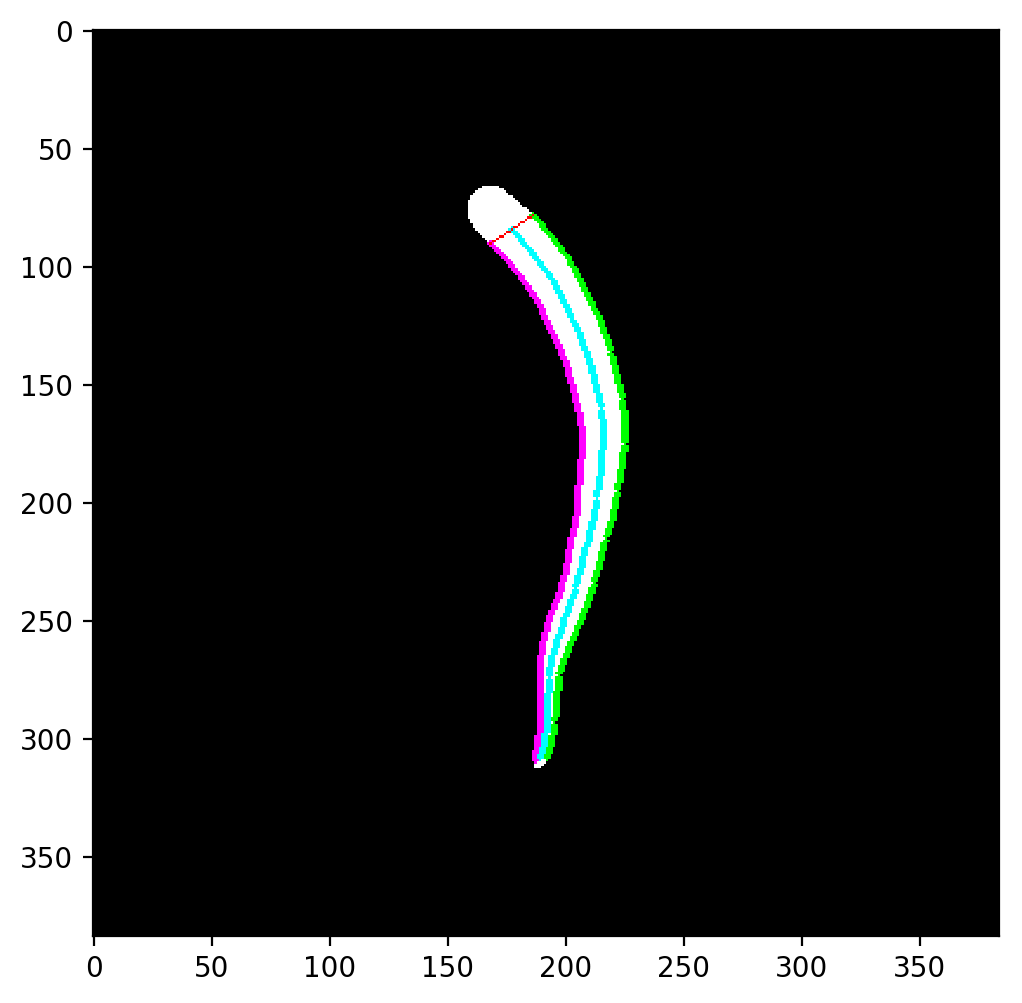

In [19]:
UNIT = 256
path ='シルエット/17Spheric/17yakumi2o06_l.jpg'
path ='シルエット/17Horn/17aomida1o02_l.jpg'

# 画像の読み込み
src = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
# 画像サイズを標準化する。
img = getstandardShape(src, unitSize=UNIT,showResult=False)
tuple,dmax = threeLinesSeq(img, showImage =  True)

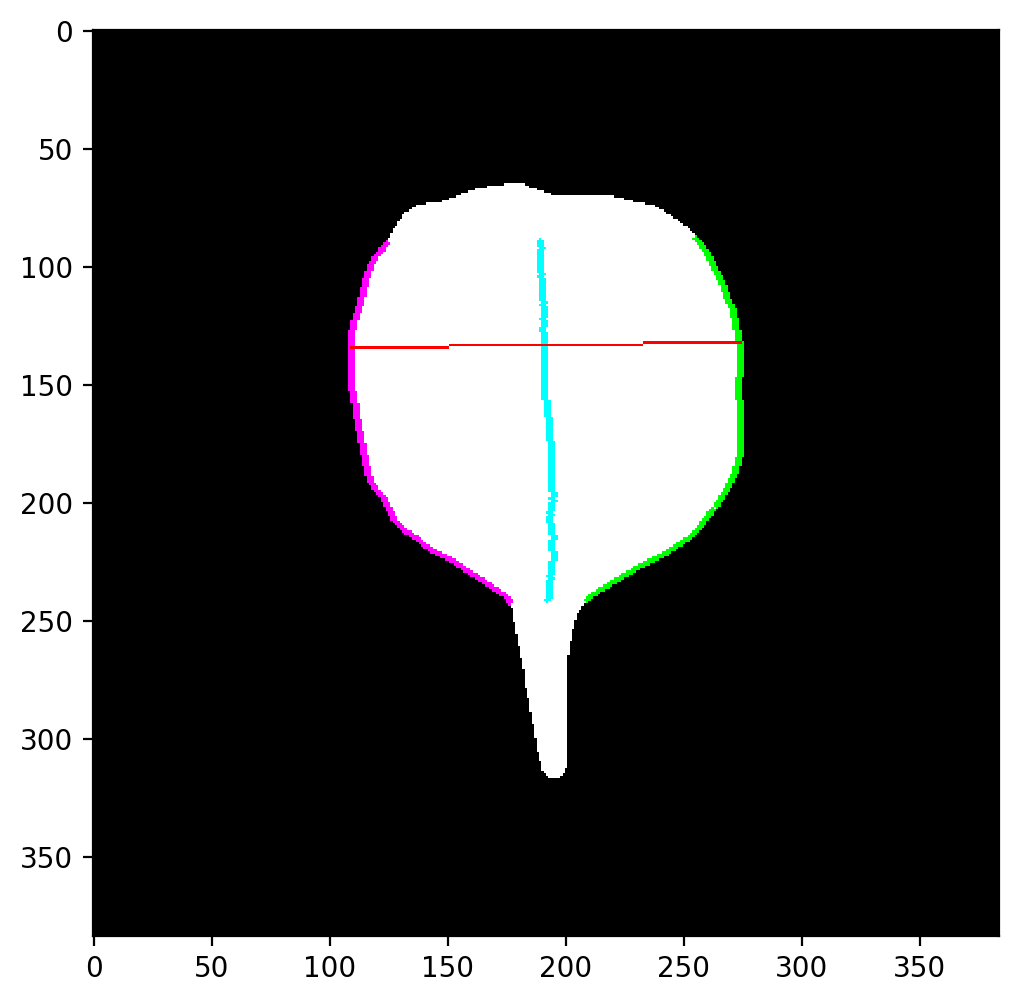

In [20]:
UNIT = 256
path ='シルエット/17Horn/17aomida1o02_l.jpg'
path ='シルエット/17Spheric/17yakumi2o06_l.jpg'

# 画像の読み込み
src = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
# 画像サイズを標準化する。
img = getstandardShape(src, unitSize=UNIT,showResult=False)
tuples,dmax = threeLinesSeq(img, showImage =  True);

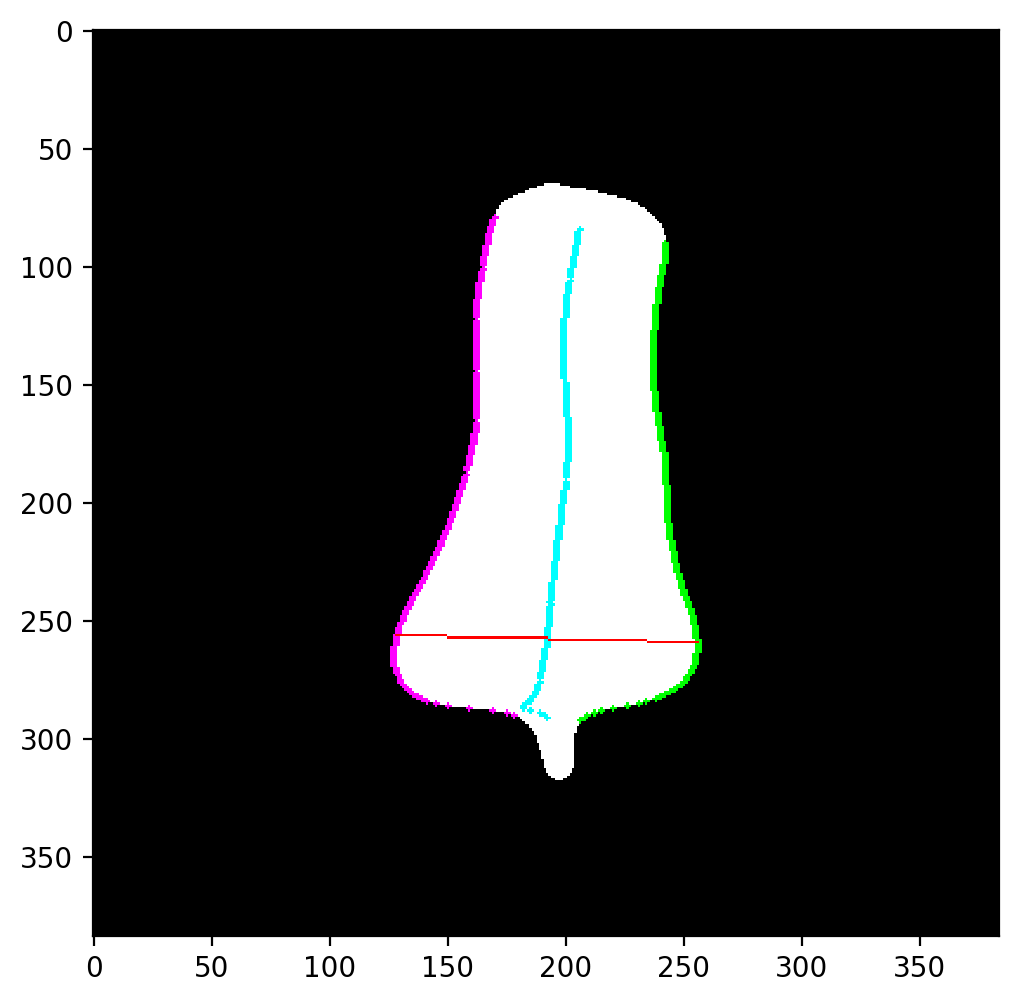

In [21]:
UNIT = 256
path ='シルエット/17Apically/17daruma6o06_l.jpg'

# 画像の読み込み
src = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
# 画像サイズを標準化する。
img = getstandardShape(src, unitSize=UNIT,showResult=False)
tuples,dmax = threeLinesSeq(img, showImage =  True);

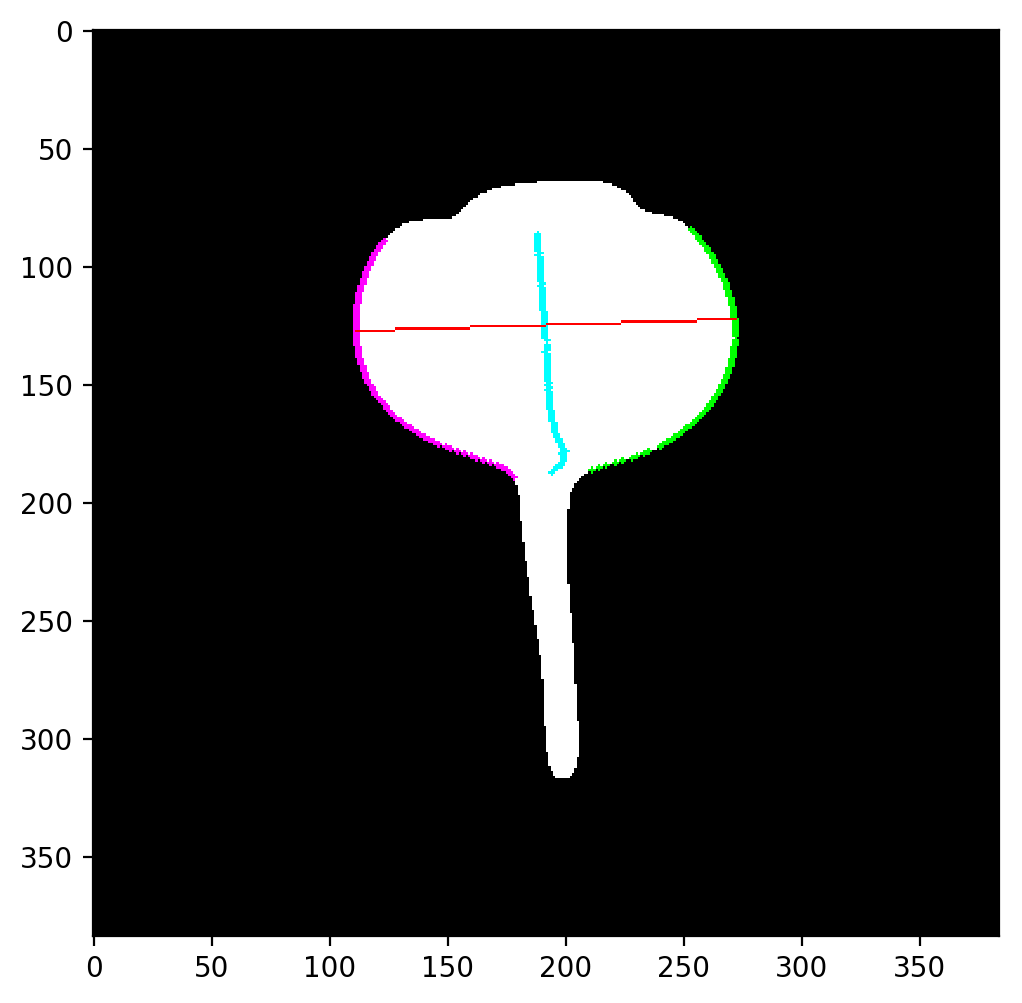

In [22]:
UNIT = 256
path='シルエット/17Tran_ellip/17heians1o07_l.jpg'
# 画像の読み込み
src = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
# 画像サイズを標準化する。
img = getstandardShape(src, unitSize=UNIT,showResult=False)
tuples,dmax  = threeLinesSeq(img, showImage =  True);

# 点列にベジエ曲線を当てはめる関数 

In [23]:
# ベジエフィッティング
def fitBezierCurve3(points,precPara=0.01,mode=2):
    # mode = 2：両端固定、　mode =3 : 下のみ固定, mode4 :  全制御点自由
    # ベジエ曲線を定義するのに使うシンボルの宣言
    P = [Symbol('P' + str(i)) for i in range(4)]
    px,py =var('px:4'),var('py:4')
    for i in range(4):
        P[i] = Matrix([px[i],py[i]]) 
    t = symbols("t")
    
    # いわゆる自乗誤差の一般式
    s,t= symbols('s,t')
    loss1 = (s - t)**2
    # 最小自乗法の目的関数の一般式
    def lossfunc(listA,listB):
        return sum([loss1.subs([(s,a),(t,b)]) for (a,b) in zip(listA,listB)])/2
    
    # ３次のベジエ曲線の定義式制御点 P0~P3 とパラメータ　　t　の関数として定義
    bez3 = (1-t)**3*P[0] + 3*(1-t)**2*t*P[1] + 3*(1-t)*t**2*P[2] + t**3*P[3]
    
    # 初期の推定パラメータの決定
    ## サンプル点間の差分を求める
    points1 = points[1:] #  ２つ目から後ろのサンプル点
    ds = points1-points[:-1] # サンプル点間の差分ベクトル
    la = [np.sqrt(e[0]*e[0]+e[1]*e[1]) for e in ds] # サンプル点間の直線距離のリスト
    axlength = np.sum(la) # 折れ線近似による経路長
    tpara0 = np.zeros(len(points),np.float32) # パラメータ格納配列
    tpara = tpara0.copy()
    tpara[0]=0.0 # 最初の点のパラメータ推定値は０とする
    for i in range(len(la)):
        tpara[i+1] = tpara[i]+la[i] # 各サンプル点での積算経路長
    tpara = tpara/axlength # 全経路長で割ってパラメータとする　（０〜１）

    #  パラメトリック曲線　linefunc 上で各サンプル点に最寄りの点のパラメータを対応づける
    def refineTpara(pl,linefunc):
        (funcX,funcY) = linefunc # funcX,funcY は t の関数
        # 各サンプル点に最も近い曲線上の点のパラメータ t を求める。
        trange = np.arange(-0.1,1.1,0.01) # 推定範囲は -0.1 〜　１．１
        onpoints = [[s,funcX.subs(t,s),funcY.subs(t,s)] for s in trange] # 曲線上の点
        tpara = np.zeros(len(pl),np.float32) # 新しい 推定 t パラメータのリスト用の変数のアロケート
        refineTparaR(pl,tpara,0,len(pl),0,len(onpoints),onpoints)
        return tpara

    # 範囲全体をサーチするのはかなり無駄なので、約６割ぐらいに狭める
    def srange(n,stt,end,smin,smax):
        if end - stt < 3 : # 残り３点未満なら全域サーチする
            left,right = smin,smax
        else:
            left = smin+0.5*(smax-smin)*(n-stt)/(end-stt-1)
            right= smax - 0.5*(smax-smin)*(end-n-1)/(end-stt-1)
        left = (int(left-0.5)   if int(left-0.5) > smin else smin)
        right = (int(right+0.5) if int(right+0.5) < smax else smax)
        return left, right
        
    #  探索範囲内での対応づけ再帰関数
    # pl 点列、(stt,end) 推定対象範囲（番号）, (smin,smax) パラメータの探索範囲         
    def refineTparaR(pl,tpara,stt,end,smin,smax,onpoints):
        if stt >end:
            return 
        else:
            nmid = int((end+stt)/2) # 探索対象の中央のデータを抜き出す
            px,py = points[nmid] # 中央のデータの座標
            smin1, smax1 = srange(nmid,stt,end,smin,smax)
            differ = onpoints[smin1:smax1].copy() 
            differ = differ - np.array([0.0,px,py]) # 差分の配列
            distance = [x*x+y*y for _t,x,y in differ] # 自乗誤差の配列
            nearest_i = smin1+np.argmin(distance) # 誤差最小のインデックス
            tpara[nmid] = onpoints[nearest_i][0] # 中央点のパラメータが決定
            if nmid-stt >= 1 : # 左にまだ未処理の点があるなら処理する
                refineTparaR(pl,tpara, stt,nmid,smin,nearest_i,onpoints)
            if end-(nmid+1) >=1 : # 右にまだ未処理の点があるなら処理する
                refineTparaR(pl,tpara,nmid+1,end,nearest_i+1,smax,onpoints) 
                
    while True:
        linepoints = [bez3.subs(t,t_) for t_ in tpara] # 曲線上の点列
        linepointsX = [x  for  [x,y] in linepoints] # X
        linepointsY = [y  for  [x,y] in linepoints] # Y
        EsumX = lossfunc(listA=points[:,0],listB=linepointsX) #  X方向のずれの評価値
        EsumY = lossfunc(listA=points[:,1],listB=linepointsY) #  Y 方向のずれの評価値
        # px0,px1, px2, px3, py1, py2,py3,py4 で偏微分
        if  mode<4:
            # P3は固定なので座標を代入
            EsumX = EsumX.subs(px[3],points[-1][0])
            EsumY = EsumY.subs(py[3],points[-1][1])
        if mode<3:
            # P0も固定なので座標を代入
            EsumX = EsumX.subs(px[0],points[0][0])
            EsumY = EsumY.subs(py[0],points[0][1])
        dx_1 = diff(EsumX,px1)
        dx_2 = diff(EsumX,px2)
        dy_1 = diff(EsumY,py1)
        dy_2 = diff(EsumY,py2)
        if mode>2:
            dx_0 = diff(EsumX,px0)
            dy_0 = diff(EsumY,py0)
        if mode>3:
            dx_3 = diff(EsumX,px3)
            dy_3 = diff(EsumY,py3)

        # 連立させて解く
        if mode == 4:
            resultX = solve([dx_0,dx_1,dx_2,dx_3],[px[0],px[1],px[2],px[3]])
            resultY = solve([dy_0,dy_1,dy_2,dy_3],[py[0],py[1],py[2],py[3]])
        elif mode ==3:
            resultX = solve([dx_0,dx_1,dx_2],[px[0],px[1],px[2]])
            resultY = solve([dy_0,dy_1,dy_2],[py[0],py[1],py[2]])
        else : # mode ==2
            resultX = solve([dx_1,dx_2],[px[1],px[2]])
            resultY = solve([dy_1,dy_2],[py[1],py[2]])
            
        # 解をベジエの式に代入
        if mode == 4:
            bezresX = bez3[0].subs([(px[0],resultX[px0]),(px[1],resultX[px1]),(px[2],resultX[px2]),(px[3],resultX[px3])])
            bezresY = bez3[1].subs([(py[0],resultY[py0]),(py[1],resultY[py1]),(py[2],resultY[py2]),(py[3],resultY[py3])])
        elif mode == 3:
            bezresX = bez3[0].subs([(px[0],resultX[px0]),(px[1],resultX[px1]),(px[2],resultX[px2]),(px[3],points[-1][0])])
            bezresY = bez3[1].subs([(py[0],resultY[py0]),(py[1],resultY[py1]),(py[2],resultY[py2]),(py[3],points[-1][1])])
        else : # mode ==2
            bezresX = bez3[0].subs([(px[0],points[0][0]),(px[1],resultX[px1]),(px[2],resultX[px2]),(px[3],points[-1][0])])
            bezresY = bez3[1].subs([(py[0],points[0][1]),(py[1],resultY[py1]),(py[2],resultY[py2]),(py[3],points[-1][1])])
            
        rx,ry = resultX,resultY
        if mode == 4:
            cpx = [rx[px0],rx[px1],rx[px2],rx[px3]]
            cpy = [ry[py0],ry[py1],ry[py2],ry[py3]]
        elif mode == 3:
            cpx = [rx[px0],rx[px1],rx[px2],points[-1][0]]
            cpy = [ry[py0],ry[py1],ry[py2],points[-1][1]]
        else: # mode==2
            cpx = [points[0][0],rx[px1],rx[px2],points[-1][0]]
            cpy = [points[0][1],rx[px1],ry[py2],points[-1][1]]
            
        tpara0 = tpara.copy()
        tpara = refineTpara(points,(bezresX,bezresY))
        diffpara = 0
        for i in range(len(tpara)) :
            diffpara += np.sqrt((tpara[i]-tpara0[i])**2)
        print("diffpara",diffpara)
        if diffpara < precPara:
            break
        
    return cpx,cpy,bezresX,bezresY
    # cpx,cpy → ４つの制御点、bezresX,bezresY ベジエ曲線の定義式

# 輪郭と軸のサンプルデータ　　data  を３本のベジエ曲線で近似する
def fitBezierAndDraw(data,mode=2):
    datal,datac,datar = data[:,0],data[:,1],data[:,2]
    # 初期の推定パラメータの決定
    cpxl,cpyl,bezXl,bezYl = fitBezierCurve3(points=datal,precPara=0.01,mode=mode)
    cpxc,cpyc,bezXc,bezYc = fitBezierCurve3(points=datac,precPara=0.01,mode=mode)
    cpxr,cpyr,bezXr,bezYr = fitBezierCurve3(points=datar,precPara=0.01,mode=mode)

    # 結果の描画
    plt.figure(figsize=(7,10),dpi=100)
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.scatter(np.array(datal)[:,0],np.array(datal)[:,1])
    plt.scatter(np.array(datac)[:,0],np.array(datac)[:,1])
    plt.scatter(np.array(datar)[:,0],np.array(datar)[:,1])
    tplins = np.linspace(-0.02, 1.02,50)
    plotx = [bezXl.subs(t,tp) for tp in tplins ]
    ploty = [bezYl.subs(t,tp) for tp in tplins ]
    plt.scatter(cpxl,cpyl)
    plt.plot(plotx,ploty)
    tplins = np.linspace(0, 1,50)
    plotx = [bezXl.subs(t,tp) for tp in tplins ]
    ploty = [bezYl.subs(t,tp) for tp in tplins ]
    plt.plot(plotx,ploty,color='red')  
    tplins = np.linspace(-0.02, 1.02,50)
    plotx = [bezXc.subs(t,tp) for tp in tplins ]
    ploty = [bezYc.subs(t,tp) for tp in tplins ]
    plt.scatter(cpxc,cpyc)
    plt.plot(plotx,ploty)
    tplins = np.linspace(0, 1,50)
    plotx = [bezXc.subs(t,tp) for tp in tplins ]
    ploty = [bezYc.subs(t,tp) for tp in tplins ]
    plt.plot(plotx,ploty,color='red')  
    tplins = np.linspace(-0.02, 1.02,50)
    plotx = [bezXr.subs(t,tp) for tp in tplins ]
    ploty = [bezYr.subs(t,tp) for tp in tplins ]
    plt.scatter(cpxr,cpyr)
    plt.plot(plotx,ploty)
    tplins = np.linspace(0, 1,50)
    plotx = [bezXr.subs(t,tp) for tp in tplins ]
    ploty = [bezYr.subs(t,tp) for tp in tplins ]
    plt.plot(plotx,ploty,color='red')  

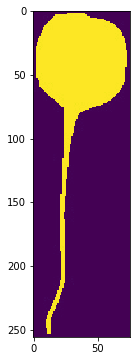

In [24]:
# src = cv2.imread('シルエット/17Apically/17daruma6o06_l.jpg')
# src = cv2.imread('シルエット/17Tran_ellip/17karami2o03_l.jpg')
# src = cv2.imread('シルエット/17Horn/17aomida1o02_l.jpg')
# src = cv2.imread('シルエット/17Tran_ellip/17heians1o07_l.jpg')
# path='シルエット/17Horn/17aomida1o02_l.jpg'
# path='シルエット/17Spheric/17yakumi2o06_l.jpg'
path ='シルエット/17Spheric/17yakumi2o06_l.jpg'
src = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
fig = plt.figure(figsize=(8,6),dpi=72)
plt.imshow(src)

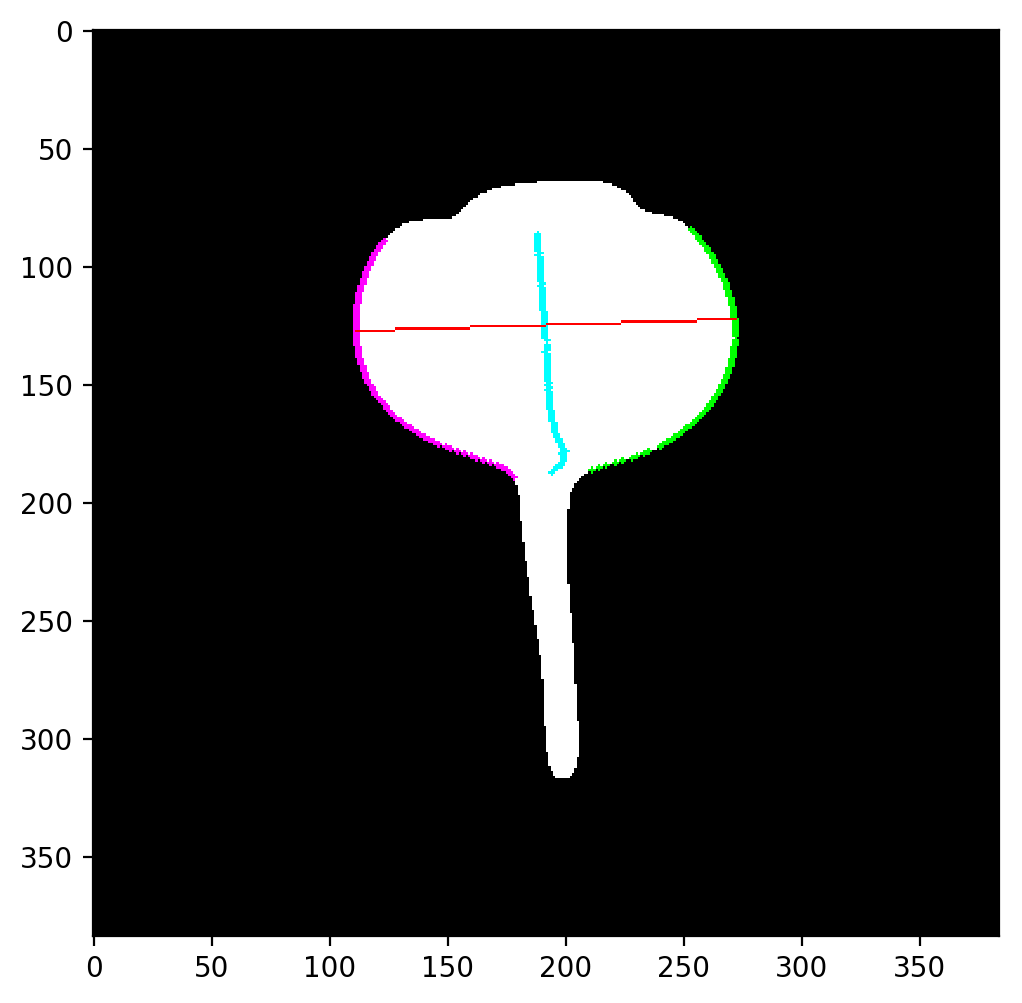

In [39]:
UNIT = 256
path='シルエット/17Tran_ellip/17heians1o07_l.jpg'
# 画像の読み込み
src = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
# 画像サイズを標準化する。
img = getstandardShape(src, unitSize=UNIT,showResult=False)
tuples,dmax  = threeLinesSeq(img, showImage =  True);

In [26]:
def lineSeg(src, showImage =  False):    
    _img,cnt,hierarchy = cv2.findContours(src, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) #  あらためて輪郭を抽出
    x0,y0,w,h = cv2.boundingRect(cnt[0])
    x = cnt[0][:,0][:,0] # 輪郭のX座標の列
    y = cnt[0][:,0][:,1] # 輪郭のY座標の列
    # 輪郭線情報は８連結のチェーンになっていることが前提
    
    x0,y0 = x[0],y[0]
    print(len(cnt[0]))
    for i in range(len(cnt[0])-1):
        print("{} xd {}  yd {} ".format(i,x[i+1]-x[i],y[i+1]-y[i]))
        if x[i+1]-x[i] > 1 and y[i+1]-y[i] > 1:
              print("Mark!!") 
    return 

In [40]:
UNIT = 256
